# Batch Normalization

The paper and my notes from it can be found [here](https://rlist.ashwinms.com/read/2f46ca50-7fbe-4f96-a560-d3a2d21a4b73)

The basic idea of batch norm to:
- train in mini-batches
- compute local statistics over a mini-batch
- use the local-stats + learnable params to form an affine map which makes normalization differentiable and part of the grad flow during backbrop. This also maintains the models expressivity and ability to propogate unit mappings.



In [33]:
import torch
import matplotlib.pyplot as plt


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Lets try to implement a simple 1D-BN

In [35]:
def do_batch_norm(
  x : torch.tensor, # This will be of dims (batch, feature-dims)
  scale: torch.tensor, # Gamma from the paper
  shift: torch.tensor, # Beta from the paper
  epsilon: float = 1e-5, # small constant to numerically stabilize normalization.
  training: bool = False,
  moving_mean: torch.tensor = None,
  moving_var: torch.tensor = None,
):
  if training:
    batch_mean = x.mean(dim=0)
    batch_std = x.std(dim=0)
    norm_x = (x - batch_mean) / torch.sqrt(torch.square(batch_std) + epsilon)
    return norm_x * scale + shift
  else:
    if not moving_mean or not moving_var:
      raise ValueError("Moving mean and variance must be provided in training mode.")
    with torch.no_grad():
      norm_x = (x - moving_mean) / torch.sqrt(moving_var + epsilon)
      return norm_x * scale + shift

In [36]:
def test_do_batch_norm_train():
  x = torch.randn((10,3))
  scale = torch.randn((3))
  shift = torch.randn(3)
  moving_mean_1 = torch.zeros(3)
  moving_var_1 = torch.ones(3)
  my_BN = do_batch_norm(x,scale,shift,training=True,moving_mean=moving_mean_1,moving_var = moving_var_1)
  torch_BN = torch.nn.functional.batch_norm(x,None, None,weight = scale,bias = shift,training=True)
  print("my BN : ", my_BN.shape)
  print("torch BN : ",torch_BN.shape)
  print("Diff: ",torch.abs(my_BN - torch_BN).max())

In [37]:
test_do_batch_norm_train()

my BN :  torch.Size([10, 3])
torch BN :  torch.Size([10, 3])
Diff:  tensor(0.0542)


We still see a small difference here , why is that?
1. `nn.F.batch_norm` internally uses biased std , but `torch.std()` by default is unbiased.
2. We can actually skip `1.` completely and directly use `tensor.var()` for variance instead of `srqt(sqr + eps)`

In [38]:
def do_batch_norm(
  x : torch.tensor, # This will be of dims (batch, feature-dims)
  scale: torch.tensor, # Gamma from the paper
  shift: torch.tensor, # Beta from the paper
  epsilon: float = 1e-5, # small constant to numerically stabilize normalization.
  training: bool = False,
  moving_mean: torch.tensor = None,
  moving_var: torch.tensor = None,
):
  if moving_mean is None or moving_var is None:
      raise ValueError("Moving mean and variance must be provided in training mode.")
  if training:
    batch_mean = x.mean(dim=0)
    batch_var = x.var(dim=0,unbiased=False) # !! UPDATED !!
    norm_x = (x - batch_mean) / torch.sqrt(batch_var + epsilon)

    # Track stats required for inference
    with torch.no_grad():
      moving_mean.lerp_( batch_mean, 0.1)
      moving_var.lerp_( batch_var, 0.1)

    return norm_x * scale + shift
  else:
    with torch.no_grad():
      norm_x = (x - moving_mean) / torch.sqrt(moving_var + epsilon)
      return norm_x * scale + shift
test_do_batch_norm_train() # The Diff should be super small!

my BN :  torch.Size([10, 3])
torch BN :  torch.Size([10, 3])
Diff:  tensor(2.3842e-07)


## Now lets see this in action in a simple model

In [39]:
import torch.nn.functional as F
from tqdm import tqdm

In [40]:
def bn_forward_pass(
  x_batch: torch.tensor,
  W1: torch.tensor,
  b1: torch.tensor,
  W2: torch.tensor,
  b2: torch.tensor,
  gamma: torch.tensor,
  beta: torch.tensor,
  training: bool = False,
  moving_mean: torch.tensor = None,
  moving_var: torch.tensor = None,
  use_bn: bool = True,
  capture_stats: bool = False,
  stats = None,
):

  if not training and use_bn:
    if moving_mean is None or moving_var is None:
      raise ValueError("Moving mean and variance must be provided in training mode.")

  # z1 = ( [batch_size,28*28] * [ 28*28,128 ] -> [batch_size,128] + [128]  )
  z1 = F.linear( x_batch , W1 , b1 )

  # just for a later viz ignore for now
  if capture_stats and stats is not None:
    z1.retain_grad()
    stats["z1"] = z1
  # ----

  # use batch norm based on passed flag
  bn1 = do_batch_norm(z1,gamma,beta,training=training,moving_mean=moving_mean,moving_var=moving_var) if use_bn else z1

  # just for a later viz ignore for now
  if use_bn and capture_stats and stats is not None:
    bn1.retain_grad()
    stats["bn1"] = bn1
  # ----

  # activation
  a1 = F.leaky_relu(bn1)

  # just for a later viz ignore for now
  if capture_stats and stats is not None:
    a1.retain_grad()
    stats["a1"] = a1
  # ----

  # logits = z2 = ( [batch_size,128] * [128,10] -> [batch_size,10] + [10]  )
  logits = F.linear(a1,W2,b2)

  return logits,stats


In [41]:
# Define the learnable model params
W1 = torch.randn((128,28*28),requires_grad=True, device=device)
b1 = torch.randn(128,requires_grad=True,device=device)

W2 = torch.randn((10,128),requires_grad=True,device=device)
b2 = torch.randn(10,requires_grad=True,device=device)

gamma = torch.randn(128,requires_grad=True,device=device)
beta = torch.randn(128,requires_grad=True,device=device)

In [42]:
# define lossfn and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W1,b1,W2,b2,gamma,beta],lr=1e-3)

In [43]:
# BN stats which are tracked in training and used for inference
# these must stay outside the optimization
moving_mean_1 = torch.zeros(128,device=device)
moving_var_1 = torch.ones(128,device=device)

In [44]:
def train_1(x,y,batch_size,epochs = 1):
  tqdm_iter = tqdm(range(epochs))
  loss_hist = []

  for e in tqdm_iter:
    for i in range(0,len(x),batch_size):
      x_batch = x[i:i+batch_size]
      y_batch = y[i:i+batch_size]

      logits,stats = bn_forward_pass(
          # all params
          x_batch,W1,b1,W2,b2,gamma,beta,
          moving_mean=moving_mean_1,
          moving_var = moving_var_1,
          training = True,

      )
      sigmoid_logits = torch.sigmoid(logits)
      preds = sigmoid_logits.argmax(dim=1)

      loss = loss_fn(logits,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_hist.append(loss.item())
    tqdm_iter.set_description(f"Epoch : {e} ,Loss : {loss.item()}")
  return loss_hist

### Loading up MNIST

(50000, 784)


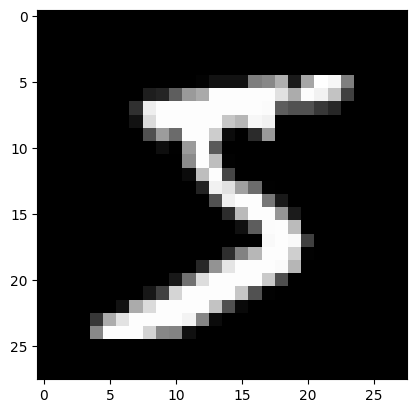

In [45]:
# @title
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
# ``pyplot.show()`` only if not on Colab
try:
    import google.colab
except ImportError:
    pyplot.show()
print(x_train.shape)


In [46]:
# @title
x_train, y_train, x_valid, y_valid = map(
    torch.from_numpy, (x_train, y_train, x_valid, y_valid)
)
x_train = x_train.to(device)
y_train = y_train.to(device)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)
n, c = x_train.shape
# print(x_train, y_train)
print("x_train shape => " ,x_train.shape)
print("y_train shape => " ,y_train.shape)
print("y range of values => ",y_train.min(), y_train.max())

x_train shape =>  torch.Size([50000, 784])
y_train shape =>  torch.Size([50000])
y range of values =>  tensor(0, device='cuda:0') tensor(9, device='cuda:0')


### Lets train the model with batch norm


In [47]:
loss_hist = train_1(x_train,y_train,64,40)


Epoch : 39 ,Loss : 0.0001622576965019107: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


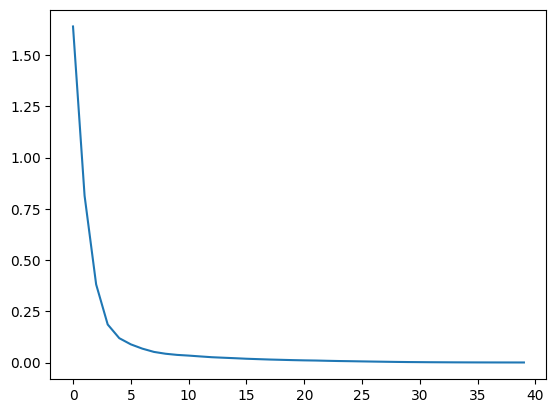

In [48]:
# @title
plt.plot(loss_hist)
plt.show()

Lets run some evals


In [49]:
# @title
def evaluate_accuracy(x, y, W1, b1, W2, b2, gamma, beta):
  print("x_test : ",x.shape)
  print("y_test : ",y.shape)

  print(f"Test stats:\n Mean: {moving_mean_1.shape}, variance: {moving_var_1.shape}")
  logits,_ = bn_forward_pass(x, W1, b1, W2, b2, gamma, beta, training=False,moving_mean=moving_mean_1,moving_var=moving_var_1)
  preds = logits.argmax(dim=1)
  accuracy = (preds == y).float().mean()
  return accuracy.item()

accuracy = evaluate_accuracy(x_valid, y_valid, W1, b1, W2, b2, gamma, beta)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

x_test :  torch.Size([10000, 784])
y_test :  torch.Size([10000])
Test stats:
 Mean: torch.Size([128]), variance: torch.Size([128])
Validation Accuracy: 96.58%


In [50]:
moving_mean_1.mean()

tensor(-0.2557, device='cuda:0')

In [51]:
moving_var_1.mean()

tensor(70.6248, device='cuda:0')

### Now lets skip using BN  and Train the same model
Getting a comparative idea of how much better the training becomes thanks to BN.

In [52]:
# @title
# Reset params
W1 = torch.randn((128,28*28),requires_grad=True, device=device)
b1 = torch.randn(128,requires_grad=True,device=device)

W2 = torch.randn((10,128),requires_grad=True,device=device)
b2 = torch.randn(10,requires_grad=True,device=device)

gamma = torch.randn(128,requires_grad=True,device=device)
beta = torch.randn(128,requires_grad=True,device=device)

# Reset loss optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W1,b1,W2,b2,gamma,beta],lr=1e-3)

In [53]:
# @title
def train_2(x,y,batch_size,epochs = 1):
  tqdm_iter = tqdm(range(epochs))
  loss_hist = []
  grad_hist = []
  for e in tqdm_iter:
    for i in range(0,len(x),batch_size):
      x_batch = x[i:i+batch_size]
      y_batch = y[i:i+batch_size]

      logits,_ = bn_forward_pass(x_batch,W1,b1,W2,b2,gamma,beta,training = True,use_bn=False) # CHANGE
      sigmoid_logits = torch.sigmoid(logits)
      preds = sigmoid_logits.argmax(dim=1)

      loss = loss_fn(logits,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    loss_hist.append(loss.item())
    tqdm_iter.set_description(f"Epoch : {e} ,Loss : {loss.item()}")
  return loss_hist

In [54]:
loss_hist = train_2(x_train,y_train,64,40)


Epoch : 39 ,Loss : 0.0: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


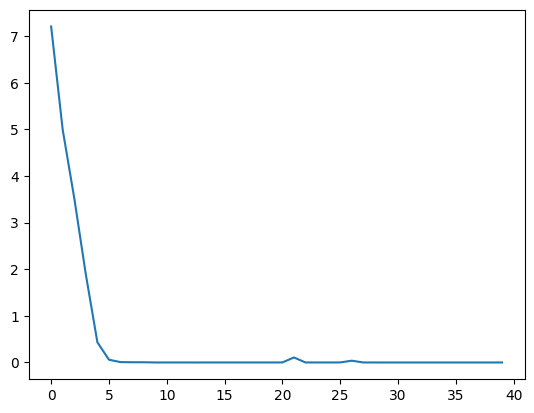

In [55]:
# @title
plt.plot(loss_hist)
plt.show()

In [56]:
# @title
def evaluate_accuracy_no_bn(x, y, W1, b1, W2, b2):
  print("x_test : ",x.shape)
  print("y_test : ",y.shape)

  logits,_ = bn_forward_pass(x, W1, b1, W2, b2, gamma, beta, training=False,use_bn=False)
  preds = logits.argmax(dim=1)
  accuracy = (preds == y).float().mean()
  return accuracy.item()


accuracy = evaluate_accuracy_no_bn(x_valid, y_valid, W1, b1, W2, b2)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

x_test :  torch.Size([10000, 784])
y_test :  torch.Size([10000])
Validation Accuracy: 95.26%


## Looking at model params and grad

Now that we've seen how BN normalizes the training process and loss, lets peek inside the model to see how the param values and udpates compare between BN and non-BN models.

There's be `train_1_with_capture` and `train_2_with_capture` which will be the same as `train_1` and `train_2` but with some additional values required to generate the below plots to visualize the param distribusion and grads.

In [57]:
# @title
def train_1_with_capture(x,y,batch_size,epochs = 1):
  tqdm_iter = tqdm(range(epochs))
  loss_hist = []
  global_stats = {}
  for e in tqdm_iter:
    for i in range(0,len(x),batch_size):
      x_batch = x[i:i+batch_size]
      y_batch = y[i:i+batch_size]

      # capture once per epoch on the first batch
      is_capture_step = i == 0

      logits,stats = bn_forward_pass(
          # all params
          x_batch,W1,b1,W2,b2,gamma,beta,
          moving_mean=moving_mean_1,
          moving_var = moving_var_1,
          training = True,
          capture_stats = is_capture_step,
          stats = {}
      )

      if is_capture_step:
        global_stats[f"{e}_{i}"] = stats

      sigmoid_logits = torch.sigmoid(logits)
      preds = sigmoid_logits.argmax(dim=1)

      loss = loss_fn(logits,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_hist.append(loss.item())
    tqdm_iter.set_description(f"Epoch : {e} ,Loss : {loss.item()}")
  return loss_hist, global_stats

In [58]:
# @title
# Reset params
W1 = torch.randn((128,28*28),requires_grad=True, device=device)
b1 = torch.randn(128,requires_grad=True,device=device)

W2 = torch.randn((10,128),requires_grad=True,device=device)
b2 = torch.randn(10,requires_grad=True,device=device)

gamma = torch.randn(128,requires_grad=True,device=device)
beta = torch.randn(128,requires_grad=True,device=device)

# define lossfn and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W1,b1,W2,b2,gamma,beta],lr=1e-3)

# BN Vars
moving_mean_1 = torch.zeros(128,device=device)
moving_var_1 = torch.ones(128,device=device)

In [59]:
loss_history_with_bn , global_stats_with_bn = train_1_with_capture(x_train,y_train,64,40)

Epoch : 39 ,Loss : 0.000895487202797085: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Similarly we will update train_2 (without BN training) to also do the capture

In [60]:
# @title
def train_2_with_capture(x,y,batch_size,epochs = 1):
  tqdm_iter = tqdm(range(epochs))
  loss_hist = []
  global_stats = {}
  for e in tqdm_iter:
    for i in range(0,len(x),batch_size):
      x_batch = x[i:i+batch_size]
      y_batch = y[i:i+batch_size]

      # capture once per epoch on the first batch
      is_capture_step = i == 0

      logits,stats = bn_forward_pass(
          # all params
          x_batch,W1,b1,W2,b2,gamma,beta,
          moving_mean=moving_mean_1,
          moving_var = moving_var_1,
          training = True,
          use_bn=False, # CHANGE
          capture_stats = is_capture_step,
          stats = {}
      )

      if is_capture_step:
        global_stats[f"{e}_{i}"] = stats

      sigmoid_logits = torch.sigmoid(logits)
      preds = sigmoid_logits.argmax(dim=1)

      loss = loss_fn(logits,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    loss_hist.append(loss.item())
    tqdm_iter.set_description(f"Epoch : {e} ,Loss : {loss.item()}")
  return loss_hist, global_stats

In [61]:
# @title
# Reset params
W1 = torch.randn((128,28*28),requires_grad=True, device=device)
b1 = torch.randn(128,requires_grad=True,device=device)

W2 = torch.randn((10,128),requires_grad=True,device=device)
b2 = torch.randn(10,requires_grad=True,device=device)

# define lossfn and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([W1,b1,W2,b2],lr=1e-3)


In [62]:
loss_history_without_bn, global_stats_without_bn = train_2_with_capture(x_train,y_train,64,40)

Epoch : 39 ,Loss : 1.5646199358343438e-07: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


### Lets Viz

> A fun exercise to do here is go back to the `def bn_forward_pass()` and change the activation function , rerun all in between cells cand look at the graphs.

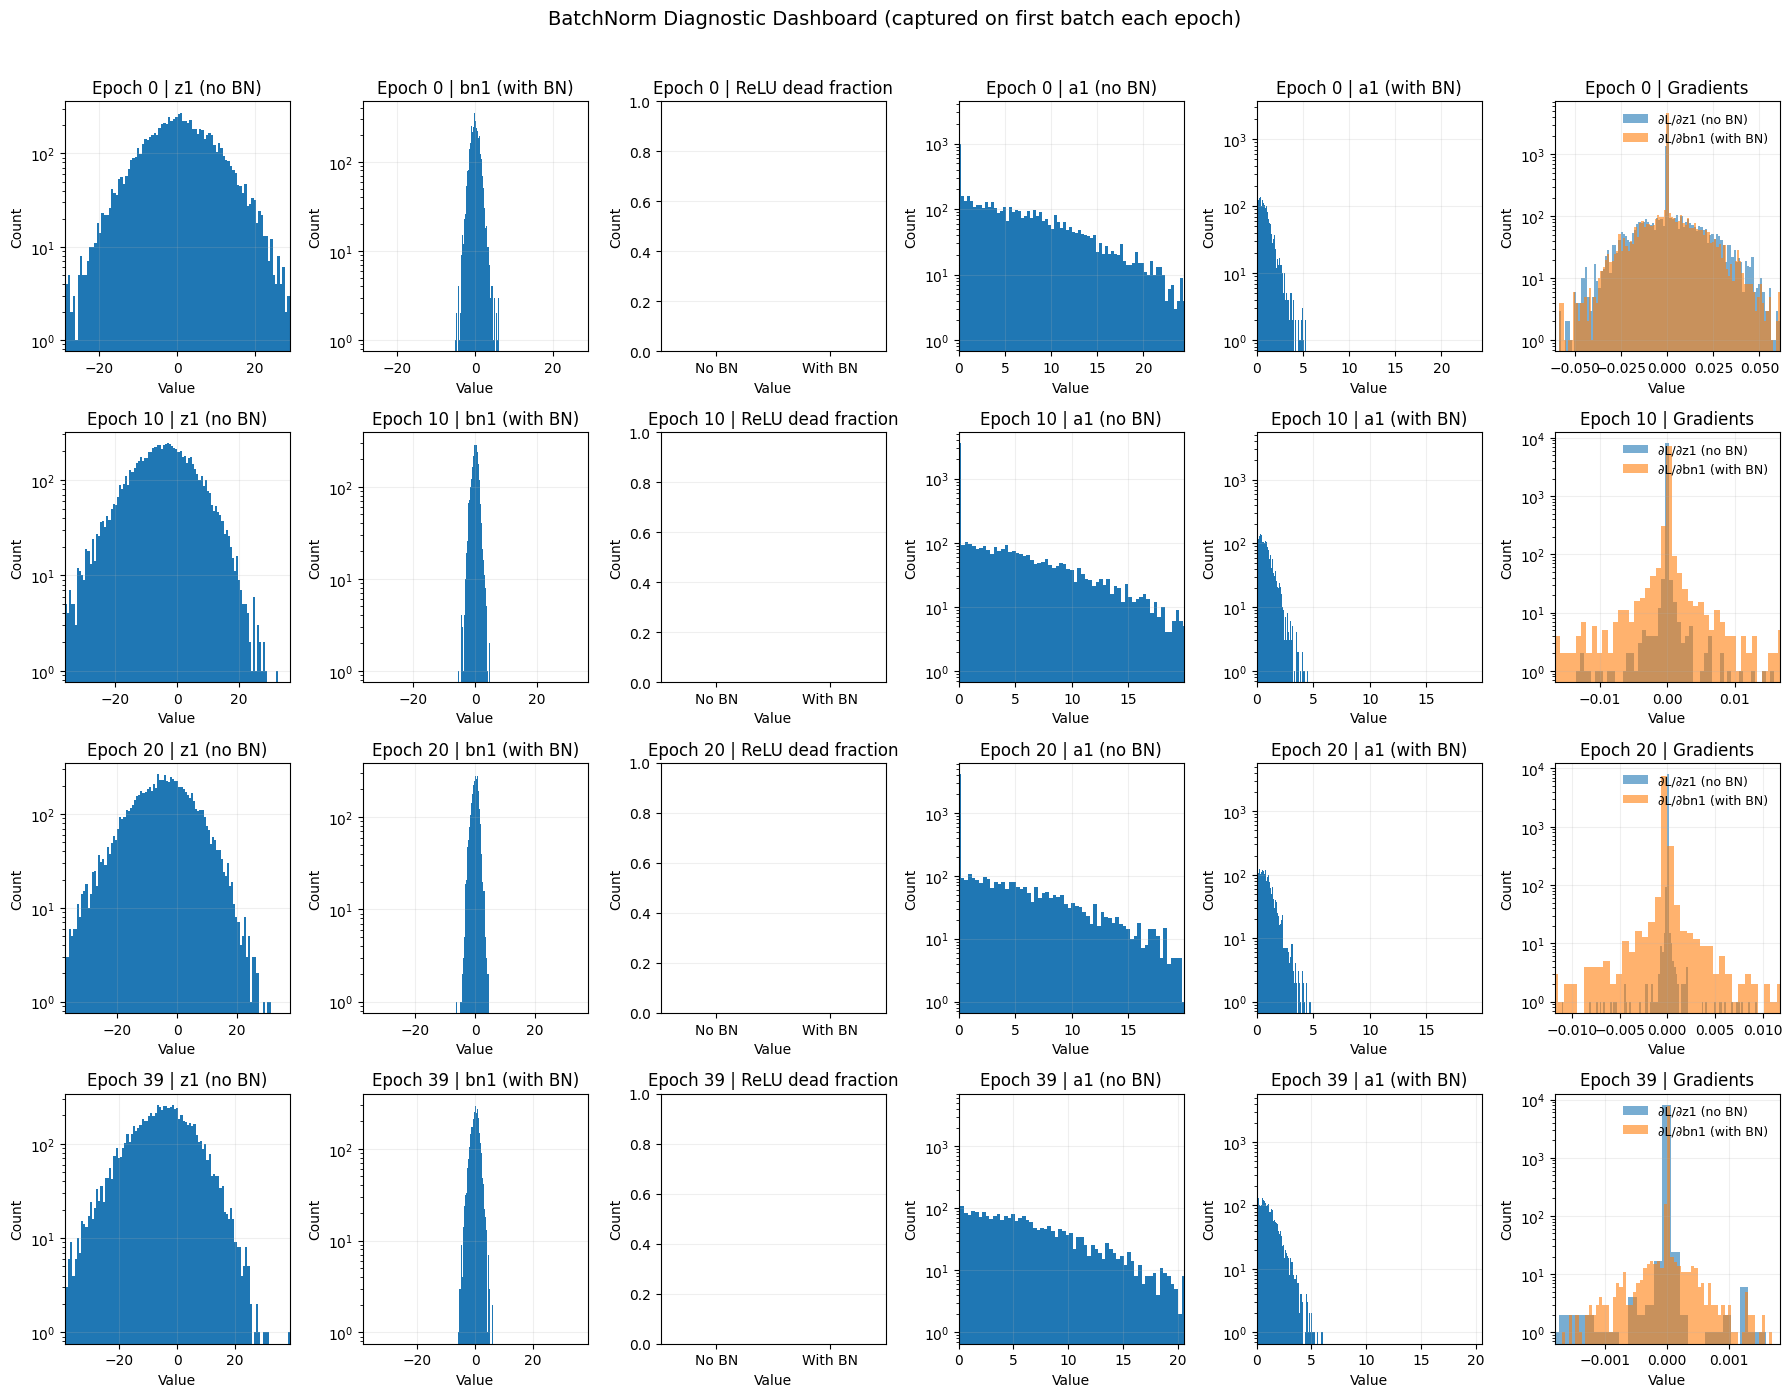

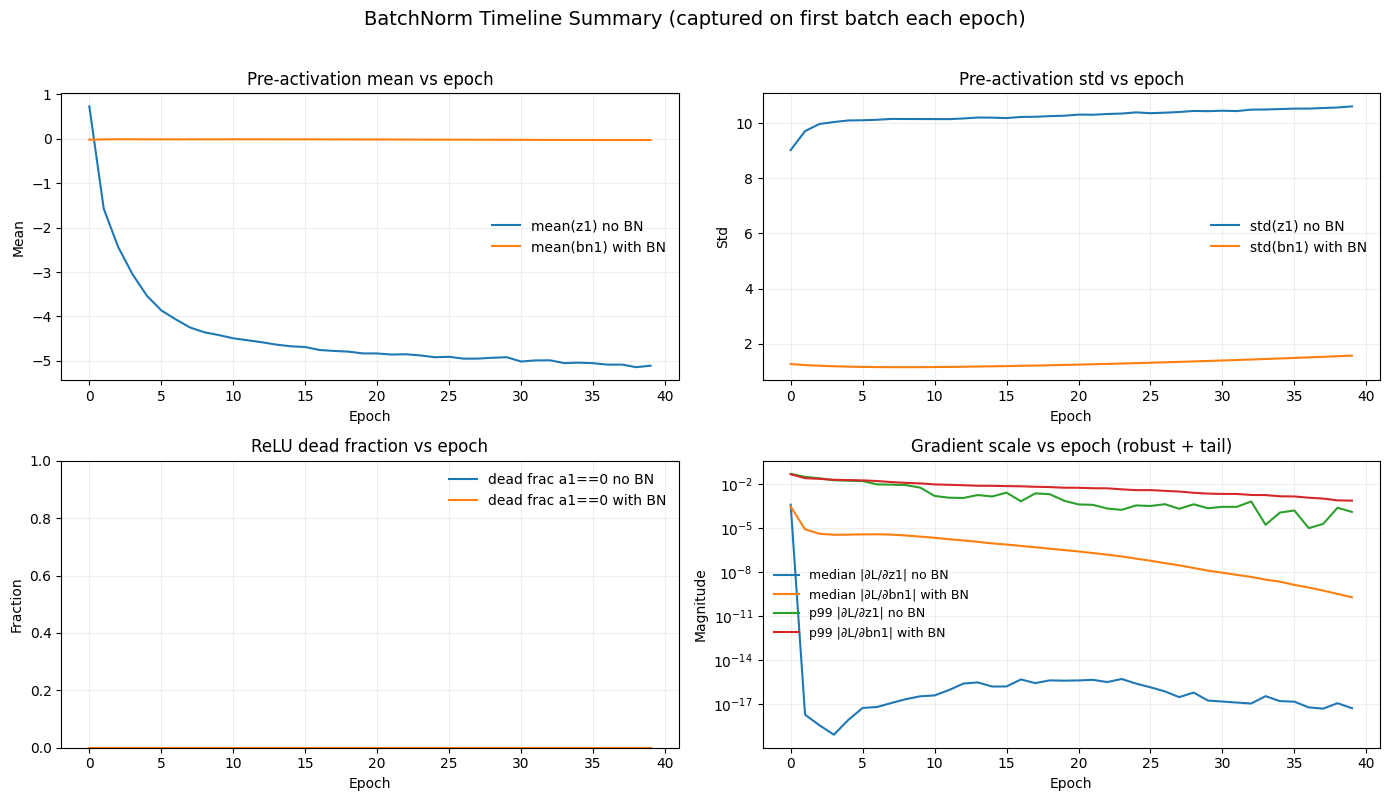

In [63]:
# @title
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _flat(t):
    return t.detach().cpu().reshape(-1).numpy()

def _get(stats, epoch, name):
    key = f"{epoch}_0"
    return stats[key][name]

def _hist(ax, data, title, bins=120, logy=True, xlim=None):
    ax.hist(data, bins=bins)
    ax.set_title(title)
    if logy:
        ax.set_yscale("log")
    if xlim is not None:
        ax.set_xlim(*xlim)
    ax.grid(True, alpha=0.2)

def _bar(ax, labels, values, title, ylabel=None, ylim=None):
    ax.bar(labels, values)
    ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    if ylim: ax.set_ylim(*ylim)
    ax.grid(True, axis="y", alpha=0.2)

def _robust_xlim(*arrays, q=0.995, pad=1.1):
    # symmetric around 0, robust to outliers
    mx = 0.0
    for a in arrays:
        a = np.asarray(a)
        mx = max(mx, np.quantile(np.abs(a), q))
    mx = mx * pad if mx > 0 else 1.0
    return (-mx, mx)

# ---------- 1) Dashboard for a few epochs ----------
def bn_dashboard(
    stats_with_bn,
    stats_without_bn,
    epochs=(0, 10, 20, 39),
    bins=120,
    logy=True,
):
    """
    For each epoch: show
      Row A: pre-activation distributions (z1 no-BN vs bn1 w/BN)
      Row B: ReLU deadness + activation distributions (a1)
      Row C: gradient distributions (dL/dz1 no-BN vs dL/dbn1 w/BN)
    """
    epochs = list(epochs)
    n = len(epochs)

    fig, axes = plt.subplots(
        nrows=n, ncols=6,
        figsize=(18, 3.5 * n),
        constrained_layout=False
    )

    if n == 1:
        axes = np.expand_dims(axes, 0)

    for r, e in enumerate(epochs):
        # tensors
        z1_no = _flat(_get(stats_without_bn, e, "z1"))
        a1_no = _flat(_get(stats_without_bn, e, "a1"))
        g_z1_no = _flat(_get(stats_without_bn, e, "z1").grad)

        bn1_yes = _flat(_get(stats_with_bn, e, "bn1"))
        a1_yes = _flat(_get(stats_with_bn, e, "a1"))
        g_bn1_yes = _flat(_get(stats_with_bn, e, "bn1").grad)

        # robust x-lims for comparability
        xlim_pre = _robust_xlim(z1_no, bn1_yes)
        xlim_grad = _robust_xlim(g_z1_no, g_bn1_yes)

        dead_no = float((a1_no == 0).mean())
        dead_yes = float((a1_yes == 0).mean())

        # ----- Row layout (6 columns) -----
        # [0,1]: pre-activation hists
        _hist(axes[r, 0], z1_no, f"Epoch {e} | z1 (no BN)", bins=bins, logy=logy, xlim=xlim_pre)
        _hist(axes[r, 1], bn1_yes, f"Epoch {e} | bn1 (with BN)", bins=bins, logy=logy, xlim=xlim_pre)

        # [2]: deadness bar
        _bar(
            axes[r, 2],
            ["No BN", "With BN"],
            [dead_no, dead_yes],
            f"Epoch {e} | ReLU dead fraction",
            ylabel="Fraction a1 == 0",
            ylim=(0, 1)
        )

        # [3,4]: activation output hists (a1)
        # For a1, keep same xlim based on both to compare spread of positive activations
        xlim_a1 = (0, np.quantile(np.concatenate([a1_no, a1_yes]), 0.995) * 1.1 + 1e-9)
        _hist(axes[r, 3], a1_no, f"Epoch {e} | a1 (no BN)", bins=bins, logy=logy, xlim=xlim_a1)
        _hist(axes[r, 4], a1_yes, f"Epoch {e} | a1 (with BN)", bins=bins, logy=logy, xlim=xlim_a1)

        # [5]: gradient hists overlay (single axis to compare directly)
        axg = axes[r, 5]
        axg.hist(g_z1_no, bins=bins, alpha=0.6, label="∂L/∂z1 (no BN)")
        axg.hist(g_bn1_yes, bins=bins, alpha=0.6, label="∂L/∂bn1 (with BN)")
        axg.set_title(f"Epoch {e} | Gradients")
        if logy:
            axg.set_yscale("log")
        axg.set_xlim(*xlim_grad)
        axg.grid(True, alpha=0.2)
        axg.legend(frameon=False, fontsize=9)

        # tidy axis labels
        for c in range(6):
            axes[r, c].set_xlabel("Value")
            axes[r, c].set_ylabel("Count")

    fig.suptitle("BatchNorm Diagnostic Dashboard (captured on first batch each epoch)", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


# ---------- 2) Timeline summaries across all captured epochs ----------
def bn_timeline(stats_with_bn, stats_without_bn):
    """
    Plots across epochs (first batch only):
      - mean/std of pre-activations
      - ReLU dead fraction
      - gradient scale (median abs, 99th abs)
    """
    # get sorted epochs from keys like "e_0"
    epochs = sorted({int(k.split("_")[0]) for k in stats_with_bn.keys()})

    def collect(stats, use_bn):
        mu_pre, sd_pre = [], []
        dead = []
        g_medabs, g_p99abs = [], []

        for e in epochs:
            if use_bn:
                pre = _flat(_get(stats, e, "bn1"))
                g = _flat(_get(stats, e, "bn1").grad)
                a1 = _flat(_get(stats, e, "a1"))
            else:
                pre = _flat(_get(stats, e, "z1"))
                g = _flat(_get(stats, e, "z1").grad)
                a1 = _flat(_get(stats, e, "a1"))

            mu_pre.append(float(pre.mean()))
            sd_pre.append(float(pre.std()))
            dead.append(float((a1 == 0).mean()))

            abs_g = np.abs(g)
            g_medabs.append(float(np.median(abs_g)))
            g_p99abs.append(float(np.quantile(abs_g, 0.99)))

        return np.array(mu_pre), np.array(sd_pre), np.array(dead), np.array(g_medabs), np.array(g_p99abs)

    mu_no, sd_no, dead_no, gmed_no, gp99_no = collect(stats_without_bn, use_bn=False)
    mu_bn, sd_bn, dead_bn, gmed_bn, gp99_bn = collect(stats_with_bn, use_bn=True)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Pre-activation mean/std
    ax = axes[0, 0]
    ax.plot(epochs, mu_no, label="mean(z1) no BN")
    ax.plot(epochs, mu_bn, label="mean(bn1) with BN")
    ax.set_title("Pre-activation mean vs epoch")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Mean")
    ax.grid(True, alpha=0.2)
    ax.legend(frameon=False)

    ax = axes[0, 1]
    ax.plot(epochs, sd_no, label="std(z1) no BN")
    ax.plot(epochs, sd_bn, label="std(bn1) with BN")
    ax.set_title("Pre-activation std vs epoch")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Std")
    ax.grid(True, alpha=0.2)
    ax.legend(frameon=False)

    # ReLU deadness
    ax = axes[1, 0]
    ax.plot(epochs, dead_no, label="dead frac a1==0 no BN")
    ax.plot(epochs, dead_bn, label="dead frac a1==0 with BN")
    ax.set_title("ReLU dead fraction vs epoch")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Fraction")
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.2)
    ax.legend(frameon=False)

    # Gradient scale
    ax = axes[1, 1]
    ax.plot(epochs, gmed_no, label="median |∂L/∂z1| no BN")
    ax.plot(epochs, gmed_bn, label="median |∂L/∂bn1| with BN")
    ax.plot(epochs, gp99_no, label="p99 |∂L/∂z1| no BN")
    ax.plot(epochs, gp99_bn, label="p99 |∂L/∂bn1| with BN")
    ax.set_title("Gradient scale vs epoch (robust + tail)")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Magnitude")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.2)
    ax.legend(frameon=False, fontsize=9)

    fig.suptitle("BatchNorm Timeline Summary (captured on first batch each epoch)", fontsize=14, y=0.995)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


# ---------- run ----------
bn_dashboard(global_stats_with_bn, global_stats_without_bn, epochs=(0, 10, 20, 39), bins=120, logy=True)
bn_timeline(global_stats_with_bn, global_stats_without_bn)
